### Creación del dataset para estimar alphas y selección de modelos RNN

A partir del dataset de los alphas anualizados, se creará un dataset para entrenar y testear el modelo RNN que estime el alpha actual a partir de los cinco alphas anteriores.

El dataset consistirá entonces en grupos de seis datos consecutivos, con sus valores alpha residual y alpha, y donde los cinco primeros actuarán de características y el sexto con valor alpha residual será el alpha a estimar.

Como hay pocos datos en un activo si se rola por año, se incluirán todos los activos en el mismo dataset, con la restricción de que cada grupo sólo contendrá datos de un activo, de esta manera no solo se tendrán más datos para entrenar, sino que el modelo entrenado con este dataset podrá estimar alphas de cualquier activo, incluso de activos no incluidos en el dataset.

Se crearán dos datasets, uno para entrenar a la red, con el periodo de [2008:2018], y otro de test con el periodo de [2019:2024].

Se probarán diferentes modelos de RNN junto con el modelo dummy (estima el alpha actual con el alpha anterior), para ver si existe algún modelo RNN que mejore significativamente el MSE del dummy de las estimaciones sobre los conjuntos train,eval y test.


In [41]:
#Importamos las librerias necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, BatchNormalization, MaxPooling1D, Attention
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
from joblib import dump, load

%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

from modulos.tfm_util import metrica_cartera
from modulos.tfm_util import drwdown

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Se cargan los alphas anualizados, se añaden los alpha residual y se crean los dataset train y test

In [42]:
df_alpha = pd.read_csv("../datos/alphas_ann.csv", index_col=0)
df_alpha_res = df_alpha.sub(df_alpha.SPY, axis=0)
df_alpha = df_alpha.drop(columns = "SPY")
df_alpha_res = df_alpha_res[df_alpha.columns]

alpha_res_tr = df_alpha_res.loc["2008":"2018"]
alpha_res_ts = df_alpha_res.loc["2019":"2024"]
alpha_tr = df_alpha.loc["2008":"2018"]
alpha_ts = df_alpha.loc["2019":"2024"]

### Estadisticas de los alphas residuales

El 75% tienen un alpha residual inferior al 4%

In [43]:
df_alpha_res.mean().describe()

count    256.000000
mean      -0.008075
std        0.163904
min       -2.333124
25%       -0.031404
50%        0.002820
75%        0.039898
max        0.212710
dtype: float64

### Para todos los activos, se crean los grupos de 6 datos a partor del dataset de alphas relativos para train y test

In [44]:
def crear_agrupacion (datos_res, datos, tam_grupo):
    '''
    Se crean las agrupaciones de secuencia 6 registros de alphas relativo y alphas, las cinco primeras son los atributos,
    y la sexta, en la posición alpha relativo, el valor a estimar
    no el valor a predecir.
    
    Devuelve la matriz de las agrupaciones
    '''

    num_grupos_activo = datos.shape[0]-tam_grupo +1
    num_activos = len(datos.columns)

    agrup = np.zeros((num_grupos_activo*num_activos,tam_grupo,2))

    for a in range(num_activos):
        for i in range(0, num_grupos_activo):
            activo = datos.columns[a]
            # Se rechazan los activos que tienen rentabilidad 0 en 6 o más años consecutivos (no tienen precio)
            if datos.iloc[i:i+tam_grupo][activo].sum() == 0:
                continue

            agrup[i + a*num_grupos_activo,:,0] = datos_res.iloc[i:i+tam_grupo][activo]
            agrup[i + a*num_grupos_activo,:,1] = datos.iloc[i:i+tam_grupo][activo]

    # elimina las filas que tengan 0 en la posición 1, eso es porque los activos que no se han añadido han dejado a 0
    # estas filas 
    mask = ~(agrup[:, :, 1] == 0).all(axis=1)
    agrup = agrup[mask]
    
    return agrup

alphagr_tr = crear_agrupacion (alpha_res_tr, alpha_tr, 6)
alphagr_ts = crear_agrupacion (alpha_res_tr, alpha_ts, 6)

In [45]:
alphagr_tr.shape, alphagr_ts.shape

((1536, 6, 2), (253, 6, 2))

### Se normalizarán los datos a una distribución normal (0,1), ajustando el rango de valores a [0:1]

In [46]:
def fit_zscore01 (array):
    #media = np.mean(np.mean(array, axis=0))
    std_dev = np.std(np.std(array, axis=0))
    media = np.mean(array)
    std_dev = np.std(array)
    array_normalizado = (array - media) / std_dev

    #array_min = np.min(np.min(array_normalizado, axis=0))
    #array_max = np.max(np.max(array_normalizado, axis=0))
    array_min  = np.min(array_normalizado)
    array_max  = np.max(array_normalizado)

    return media, std_dev, array_min, array_max

def norm_zscore01(array, media, std_dev, array_min, array_max):
    array_normalizado = (array - media) / std_dev
    array_reescalado = (array_normalizado - array_min) / (array_max - array_min)

    return array_reescalado

# Función para desnormalizar los datos
def desnorm_zscore01(array_normalizado, media, std_dev, array_min, array_max):
    # Revertir el escalado entre 0 y 1
    array_normalizado = array_normalizado * (array_max - array_min) + array_min

    # Revertir el Z-score
    array_original = array_normalizado * std_dev + media

    return array_original

media, std_dev, array_min, array_max = fit_zscore01 (alphagr_tr)
alphagr_nm = norm_zscore01(alphagr_tr, media, std_dev, array_min, array_max)

XX_tr = alphagr_nm[:,0:-1,:]
YY_tr = alphagr_nm[:,-1,0]

alphagr_nm = norm_zscore01(alphagr_ts, media, std_dev, array_min, array_max)
XX_ts = alphagr_nm[:,0:-1,:]
YY_ts = alphagr_nm[:,-1,0]


In [47]:
# Prueb de que la normalización y desnormalización generan los mismos valores en el dataset de test

In [48]:
alphagr_ts_1 = desnorm_zscore01(alphagr_nm, media, std_dev, array_min, array_max)
print("Forma del array original:", alphagr_ts.shape)
print("Forma del array recuperado:", alphagr_nm.shape)
print("¿Son iguales los arrays original y recuperado?", np.allclose(alphagr_ts, alphagr_ts_1))

Forma del array original: (253, 6, 2)
Forma del array recuperado: (253, 6, 2)
¿Son iguales los arrays original y recuperado? True


In [49]:

def build_model_regresion(X):
    '''
    Se implementa el modelo de regresión lineal, con una sola capa densa de una neurona sin función de activación
    Se le pasa la variable de entrada X para recoger las dimensiones de la entrada
    
    '''
    
    model_name = "REGRESION"
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(XX_tr.shape[1],XX_tr.shape[2])))
    model.add(keras.layers.Dense(1, activation=None))
    
    return model, model_name

def build_model_LSTM(X):
    '''
    Se implementa el modelo LSTM con una sola capa LSTM de tamaño temporal XX.shape[1] y canales XX.shape[2]
    La salida es una capa densa de una sola neurona sin función de activación
    Se le pasa la variable de entrada X para recoger las dimensiones de la entrada
    
    '''

    model_name = "LSTM"
    model = keras.Sequential()

    #return_sequences=True. Devuelve como salida toda la secuencia temporal en lugar de la última para la entrada de la siguiente capa
    #Como salida devuelve la misma dimensión temporal que la entrada

    model.add(keras.layers.LSTM(X.shape[1], input_shape=(X.shape[1],X.shape[2],), return_sequences=True))
    model.add(keras.layers.Flatten())
    model.add(Dense(1, activation=None))

    return model, model_name

def build_model_GRU(X):
    '''
    Se implementa el modelo GRU de la misma manera que el modelo LSTM
    Se le pasa la variable de entrada X para recoger las dimensiones de la entrada
    
    '''
    
    model_name = "GRU"
    model = keras.Sequential()

    #return_sequences=True. Devuelve como salida toda la secuencia temporal en lugar de la última para la entrada de la siguiente capa
    #Como salida devuelve la misma dimensión temporal que la entrada

    model.add(keras.layers.GRU(X.shape[1], input_shape=(X.shape[1],X.shape[2],), return_sequences=True))
    model.add(keras.layers.Flatten())
    model.add(Dense(1, activation=None))

    return model, model_name

def build_model_CONV(X):
    '''
    Se implementa un modelo convolucional de una capas de 16 filtros de tamaño 2 con pooling de 2 para reducir la dimensión de las salidas
    Se le pasa la variable de entrada X para recoger las dimensiones de la entrada
    
    '''

    model_name = "CONV"
 
    model = keras.Sequential()
    model.add(keras.layers.Convolution1D(filters=16, kernel_size=2, activation='relu', input_shape=(X.shape[1],X.shape[2])))
    model.add(MaxPooling1D(2))
    #model.add(keras.layers.Convolution1D(filters=8, kernel_size=2))
    #model.add(MaxPooling1D(2))
    model.add(keras.layers.Flatten())
    model.add(Dense(1, activation=None))
              
    return model, model_name


def build_model_attention (X):
    '''
    Se implementa un modelo de atención con tres capas densas (query, value y key) para transformar la salida de la capa LSTM en vectores de 
    consulta, de valor y de clave como entrada en la capa attention
    Se le pasa la variable de entrada X para recoger las dimensiones de la entrada
    
    '''
    
    model_name = "ATTENTION"

    XX = Input((X.shape[1],X.shape[2],))
    out = LSTM(10, return_sequences = True)(XX)

    query = Dense(X.shape[1])(out)
    value = Dense(X.shape[1])(out)
    key = Dense(X.shape[1])(out)

    out = Attention(use_scale=False)([query,value,key])
    out = Flatten()(out)
    out = Dense(1, activation=None)(out)

    model = Model(inputs=XX, outputs=out)
    
    return model, model_name

def build_model_bidireccional (X):
    '''
    Se implementa un modelo bidireccional asimétrico (GRU para forward yt LSTM para backward)
    Se le pasa la variable de entrada X para recoger las dimensiones de la entrada
    
    '''
    
    model_name = "BIDIRECCIONAL"

    model = keras.Sequential()

    forward_layer = keras.layers.GRU(20,activation='relu',return_sequences=True)
    backward_layer = keras.layers.LSTM(20, activation='relu',return_sequences=True, go_backwards=True)

    model.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer,
                             input_shape=(X.shape[1],X.shape[2])))

    model.add(Flatten()) 
    model.add(Dense(1, activation=None))
    
    return model, model_name

    
    
def fit_eval_model (build_model, X, Y, Xt, Yt):
    '''
    
    Crea y entrena el modelo build_model con los datos de train X,Y
    y lo evalua con los datos de test Xt,Yt
    Saca la gráfica del entrenamiento 
    Devuelve los MSE de train, evaluación y test multiplicados por el factor de normalización maxdatos
    
    Si se introduce None en build_model, se predice con el valor anterior de la serie (modelo dummy)
    
    '''
    
    # Los datos de entrenamiento se desglosan en 80% entrenamiento y el 20% de evaluación
    Xtr, Xval, Ytr, Yval = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    if build_model == None:
        model_name = "DUMMY"
        
        Ytr = desnorm_zscore01(Ytr, media, std_dev, array_min, array_max)
        Yval = desnorm_zscore01(Yval, media, std_dev, array_min, array_max)
        Yt = desnorm_zscore01(Yt, media, std_dev, array_min, array_max)

        mse_tr =  np.mean(np.square(Ytr - np.roll(Ytr, shift=1)))
        mse_val =  np.mean(np.square(Yval - np.roll(Yval, shift=1)))
        mse_test =  np.mean(np.square(Yt - np.roll(Yt, shift=1)))

        print (f"MSE modelo {model_name} en datos de train: {mse_tr}, validación: {mse_val} y test: {mse_test}")

        return None, model_name, mse_tr, mse_val, mse_test

    else:

        # Establecer semillas
        np.random.seed(42)
        tf.random.set_seed(42)
        model, model_name = build_model(X)

        _learning_rate = 0.01
        _epochs = 100
        _batch_size = 32
        
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=_learning_rate), 
              loss=['mse'],
              metrics=['mse'])

        hist = model.fit(Xtr,
                         Ytr,
                         epochs=_epochs,
                         validation_data=(Xval, Yval),
                         batch_size=_batch_size,
                         verbose = 0)

        plt.figure(figsize=(10,6))
        plt.subplot(1,2,1)
        plt.title (model_name)
        plt.plot(hist.history['loss'],label="loss")
        plt.plot(hist.history['val_loss'],label="val_loss")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(hist.history['mse'],label="mse")
        plt.plot(hist.history['val_mse'],label="val_mse")
        plt.legend()
        plt.savefig(f'{model_name}.png')

        #_loss, mse_tr = model.evaluate(Xtr, Ytr, verbose=0)
        #_loss, mse_val = model.evaluate(Xval, Yval, verbose=0)
        #_loss, mse_test = model.evaluate(Xt, Yt, verbose=0)
        
        Ytr_pred = model.predict(Xtr, verbose=0)
        Yval_pred = model.predict(Xval, verbose=0)
        Yt_pred = model.predict(Xt, verbose=0)
        
        Ytr = desnorm_zscore01(Ytr, media, std_dev, array_min, array_max)
        Ytr_pred = desnorm_zscore01(Ytr_pred, media, std_dev, array_min, array_max)
        Yval = desnorm_zscore01(Yval, media, std_dev, array_min, array_max)
        Yval_pred = desnorm_zscore01(Yval_pred, media, std_dev, array_min, array_max)
        Yt = desnorm_zscore01(Yt, media, std_dev, array_min, array_max)
        Yt_pred = desnorm_zscore01(Yt_pred, media, std_dev, array_min, array_max)
        
        # Calcular el error cuadrático medio de las predicciones desnormalizadas (MSE)
        mse_tr = mean_squared_error(Ytr, Ytr_pred)
        mse_val = mean_squared_error(Yval, Yval_pred)
        mse_test = mean_squared_error(Yt, Yt_pred)

        print (f"MSE modelo {model_name} en datos de train: {mse_tr}, validación: {mse_val} y test: {mse_test}")

        return model, model_name, mse_tr, mse_val, mse_test



In [50]:
# Se crea un dataframe donde se guardarán los resultados de todos los modelos
modelos = []
nombre_modelos = np.arange(7).tolist()
result = pd.DataFrame(np.zeros((7,3)))
result.columns = ["mse_train","mse_val","mse_test"]

#### Modelo 0 (Dummy), se predice con el valor anterior del alpha residual

In [51]:
model, model_name, mse_tr, mse_val, mse_test = fit_eval_model (None, XX_tr, YY_tr, XX_ts, YY_ts)
nombre_modelos[0] = model_name
result.iloc[0].mse_train = mse_tr
result.iloc[0].mse_val = mse_val
result.iloc[0].mse_test = mse_test
result.index = nombre_modelos
modelos.append(model)

MSE modelo DUMMY en datos de train: 0.2613932829101874, validación: 1.1786755586051003 y test: 0.02232109289452545


#### Modelo 1: se crea un modelo de regresión lineal para predecir las alphas residuales el dataset XX_tr, YY_tr

MSE modelo REGRESION en datos de train: 0.7314843060007012, validación: 7.357678666393757 y test: 0.13651763978409592


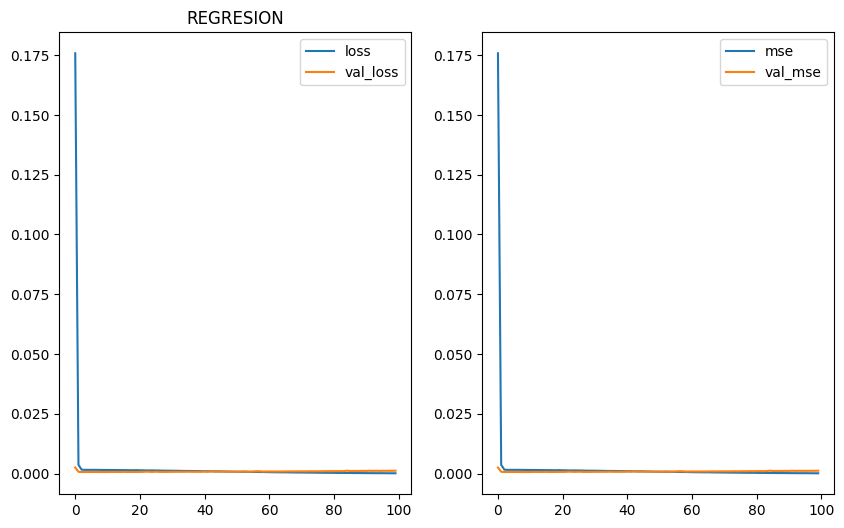

In [52]:
model, model_name, mse_tr, mse_val, mse_test = fit_eval_model (build_model_regresion, XX_tr, YY_tr, XX_ts, YY_ts)
nombre_modelos[1] = model_name
result.iloc[1].mse_train = mse_tr
result.iloc[1].mse_val = mse_val
result.iloc[1].mse_test = mse_test
result.index = nombre_modelos
modelos.append(model)

#### Modelo 2: se crea un modelo LSTM 

MSE modelo LSTM en datos de train: 0.13254087098362938, validación: 0.9500682107533002 y test: 0.017425843310066448


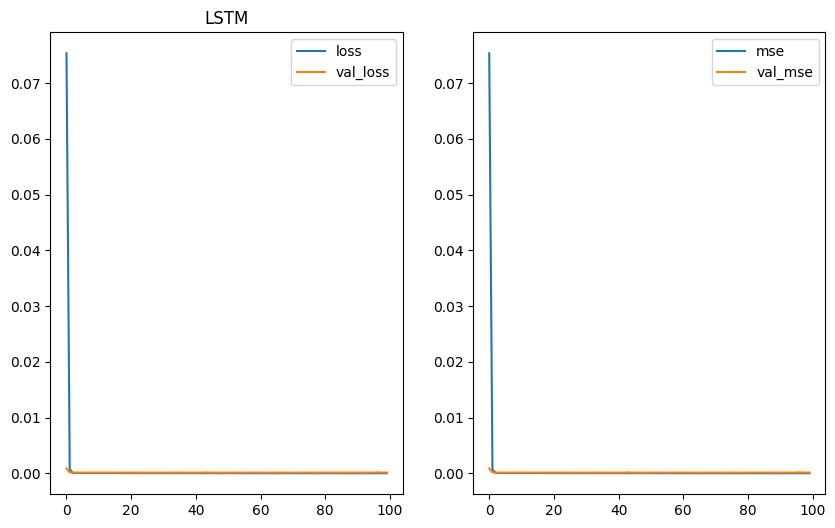

In [53]:
model, model_name, mse_tr, mse_val, mse_test = fit_eval_model (build_model_LSTM, XX_tr, YY_tr, XX_ts, YY_ts)
nombre_modelos[2] = model_name
result.iloc[2].mse_train = mse_tr
result.iloc[2].mse_val = mse_val
result.iloc[2].mse_test = mse_test
result.index = nombre_modelos
modelos.append(model)

#### Modelo 3: se crea un modelo CONV

MSE modelo CONV en datos de train: 0.11071287868609929, validación: 0.21808776029665528 y test: 0.053839051778830596


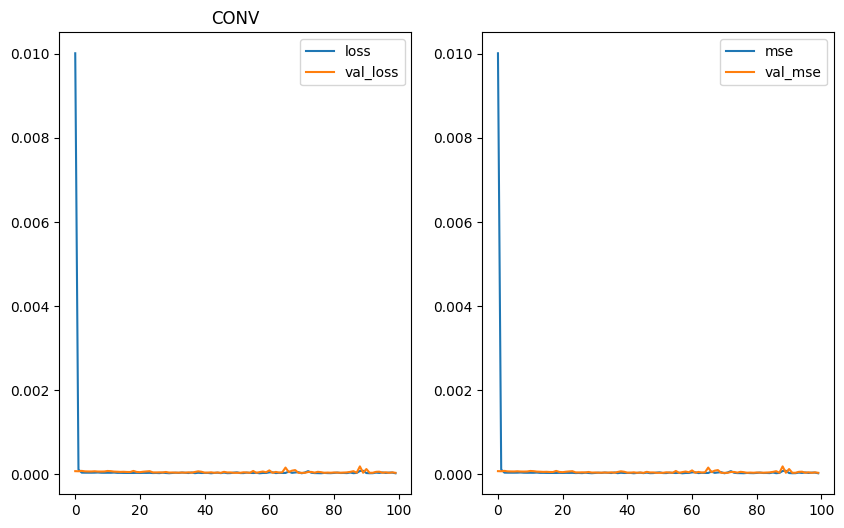

In [54]:
model, model_name, mse_tr, mse_val, mse_test = fit_eval_model (build_model_CONV, XX_tr, YY_tr, XX_ts, YY_ts)
nombre_modelos[3] = model_name
result.iloc[3].mse_train = mse_tr
result.iloc[3].mse_val = mse_val
result.iloc[3].mse_test = mse_test
result.index = nombre_modelos
modelos.append(model)

#### Modelo 4: se crea un modelo GRU 

MSE modelo GRU en datos de train: 0.0822673962595553, validación: 1.9084798297649577 y test: 0.020531143505629797


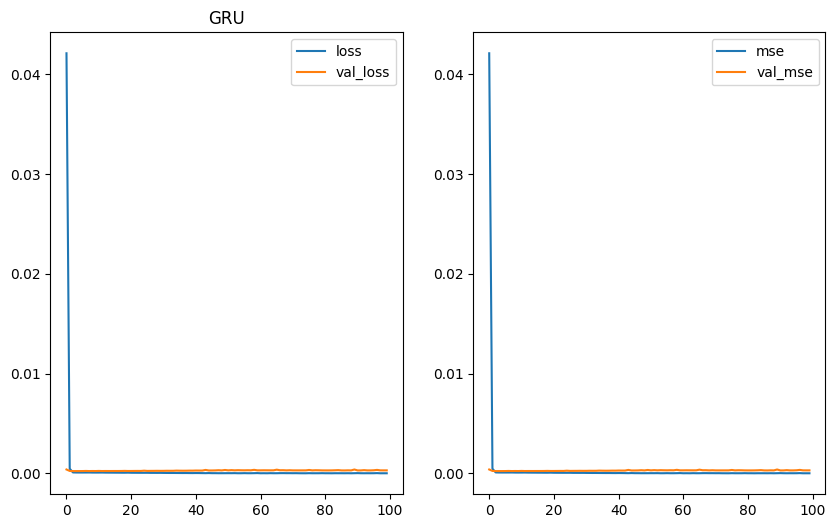

In [55]:
model, model_name, mse_tr, mse_val, mse_test = fit_eval_model (build_model_GRU, XX_tr, YY_tr, XX_ts, YY_ts)
nombre_modelos[4] = model_name
result.iloc[4].mse_train = mse_tr
result.iloc[4].mse_val = mse_val
result.iloc[4].mse_test = mse_test
result.index = nombre_modelos
modelos.append(model)

#### Modelo 5: se crea un modelo con Modelo con atención 

MSE modelo ATTENTION en datos de train: 0.12252711699021311, validación: 1.4222947823403618 y test: 0.015205439369697586


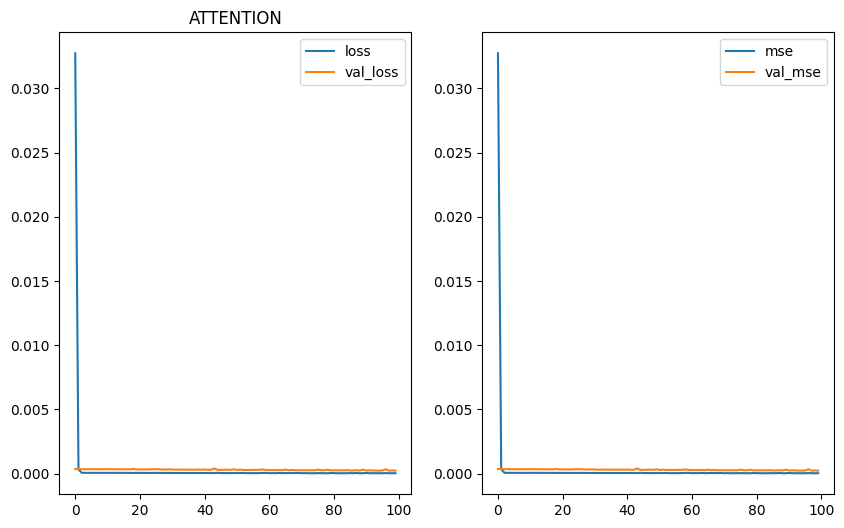

In [56]:
model, model_name, mse_tr, mse_val, mse_test = fit_eval_model (build_model_attention, XX_tr, YY_tr, XX_ts, YY_ts)
nombre_modelos[5] = model_name
result.iloc[5].mse_train = mse_tr
result.iloc[5].mse_val = mse_val
result.iloc[5].mse_test = mse_test
result.index = nombre_modelos
modelos.append(model)

#### Modelo 6: se crea un modelo con bidireccional asimétrico

MSE modelo BIDIRECCIONAL en datos de train: 0.09389115514847196, validación: 0.9423704375600029 y test: 0.014794210677268904


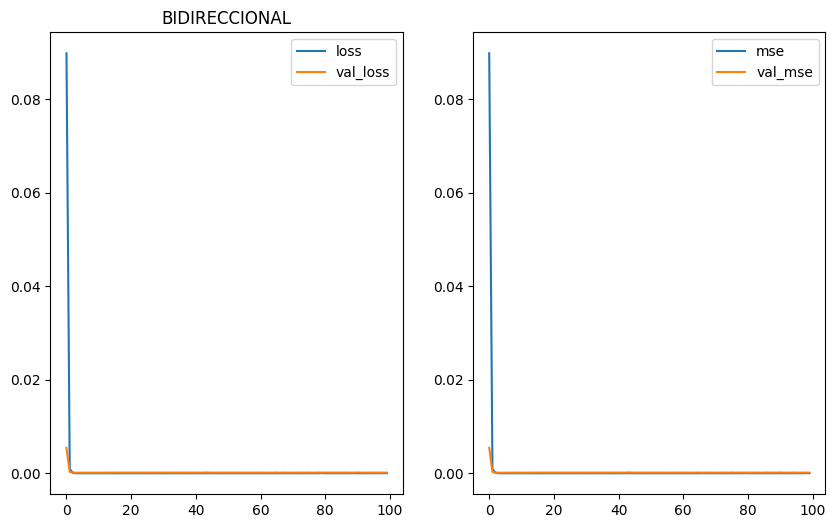

In [57]:
model, model_name, mse_tr, mse_val, mse_test = fit_eval_model (build_model_bidireccional, XX_tr, YY_tr, XX_ts, YY_ts)
nombre_modelos[6] = model_name
result.iloc[6].mse_train = mse_tr
result.iloc[6].mse_val = mse_val
result.iloc[6].mse_test = mse_test
result.index = nombre_modelos
modelos.append(model)

In [58]:
result

,mse_train,mse_val,mse_test
DUMMY,0.261393,1.178676,0.022321
REGRESION,0.731484,7.357679,0.136518
LSTM,0.132541,0.950068,0.017426
CONV,0.110713,0.218088,0.053839
GRU,0.082267,1.908480,0.020531
ATTENTION,0.122527,1.422295,0.015205
BIDIRECCIONAL,0.093891,0.942370,0.014794


### El mejor modelo RNN evaluado

Se elige como mejor modelo RNN evaluado el que tenga menor mse en la suma de los periodos eval y test

In [59]:
# Se elige el modelo con menor mse_val + mes_test
nom_modelo = (result.mse_val + result.mse_test).idxmin()
id_modelo = nombre_modelos.index(nom_modelo)

print ("Mejor modelo RNN:", nom_modelo, id_modelo)

Mejor modelo RNN: CONV 3


In [60]:
dalphas_RNN = {
    "tam_grupo":6,
    "media":media,
    "std_dev":std_dev,
    "array_min": array_min,
    "array_max": array_max,
    "modelo": modelos[id_modelo],
}
dump(dalphas_RNN, "dalphas_RNN.mdl")

['dalphas_RNN.mdl']

### CONCLUSION

Aunque hay modelos que superan al dummy en periodos de eval+test, teniendo en cuenta que el 75% de los alpha residuales caen por debajo de 0.04, y que el mejor modelo ("CONV") tiene un error mse_val de 0.21, se puede llegar a la conclusión que la estimación con modelos RNN de los alphas resduales no es fiable.

En el siguiente notebook se hará una implementación de la estragia VIXSIhedge estimando los alpha residuales con el mejor modelo encontrado.
